In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pygame

from typing import (
    Tuple,
    Dict,
    Optional,
    Iterable
)
from matplotlib import (
    animation
)
from gym import (
    spaces
)
from gym.error import (
    DependencyNotInstalled
)
from pygame import (
    gfxdraw
)
from IPython.display import (
    HTML
)

class Maze(gym.Env):
    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal  = (size - 1, size - 1)
        self.maze  = self.__create_maze__(size=size)
        self.distances = self.__compute_distance__(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {
            0: 'UP',
            1: 'RIGHT',
            2: 'DOWN',
            3: 'LEFT'
        }
        self.observation_space = spaces.MultiDiscrete([size, size])
        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self.__get_next_state__(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info
    
    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode="human") -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))

        for row in range(5):
            for col in range(5):
                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:
                        #
                        # Add the geometry of the edges and walls (i.e. the boundaries between adjacent squares that are not connected)
                        #
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)
                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))
        
        # Add the geometry of the goal square to the viewer
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer
        agent_row = int(screen_size - scale * (self.state[0] + 0.5))
        agent_col = int(scale * (self.state[1] + 0.5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * 0.6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
            np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
        )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self.__get_next_state__(state, action)

        if self.shaped_rewards:
            return -(self.distances[next_state] / self.distances.max())
        return -float(state != self.goal)
    
    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self.__get_next_state__(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def __get_next_state__(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError('Action value not supported: ', action)
        
        if next_state in self.maze[state]:
            return next_state
        
        return state


    @staticmethod
    def __create_maze__(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {
            (row, col) : [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
            for row in range(size) 
            for col in range(size)
        }

        left_edges = [
            [(row, 0), (row, -1)] 
            for row in range(size)
        ]

        right_edges = [
            [(row, size - 1), (row, size)] 
            for row in range(size)
        ]

        upper_edges = [
            [(0, col), (-1, col)] 
            for col in range(size)
        ]

        lower_edges = [
            [(size - 1, col), (size, col)] 
            for col in range(size)
        ]

        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def __compute_distance__(goal: Tuple[int, int], maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.0

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        
        return distances
    
    def display_video(self, frames):
        orig_backend = matplotlib.get_backend()
        matplotlib.use('Agg')
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        matplotlib.use(orig_backend)
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])
        im = ax.imshow(frames[0])

        def update(frame):
            im.set_data(frame)
            return [im]
        
        anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=50, blit=True, repeat=False)

        return HTML(anim.to_html5_video())
    

import seaborn as sns

def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0 : 'U', 1 : 'R', 2 : 'D', 3 : 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight' : 'bold', 'size' : 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle('Policy', size=18)
    plt.tight_layout()

def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt='.2f', cmap='coolwarm',
                annot_kws={'weight' : 'bold', 'size' : 12},
                linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def test_agent(env:Maze, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode='rgb_array'))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode='rgb_array')
            frames.append(img)
            state = next_state
    return env.display_video(frames)

### Import the necessary software libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt



In [3]:
env = Maze()

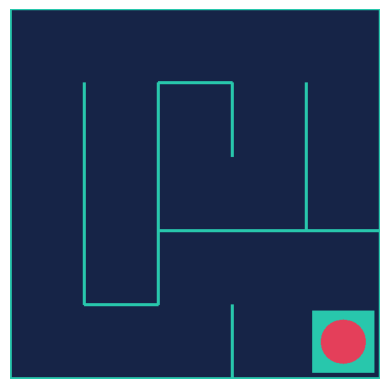

In [4]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [5]:
print(f'Observation space shape : {env.observation_space.nvec}')
print(f'Number of actions: {env.action_space.n}')

Observation space shape : [5 5]
Number of actions: 4


In [6]:
# Define the policy pi(.|s)

policy_probs = np.full((5, 5, 4), 0.25)
policy_probs

array([[[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]])

In [7]:
def policy(state):
    return policy_probs[state]

In [8]:
# Test the policy with state (0, 0)

action_probabilities = policy((0, 0))
for action, prob in zip(range(4), action_probabilities):
    print(f'Probability of taking action {action} : {prob}')

Probability of taking action 0 : 0.25
Probability of taking action 1 : 0.25
Probability of taking action 2 : 0.25
Probability of taking action 3 : 0.25


In [9]:
# See how the random policy does in the maze

test_agent(env, policy, episodes=1)

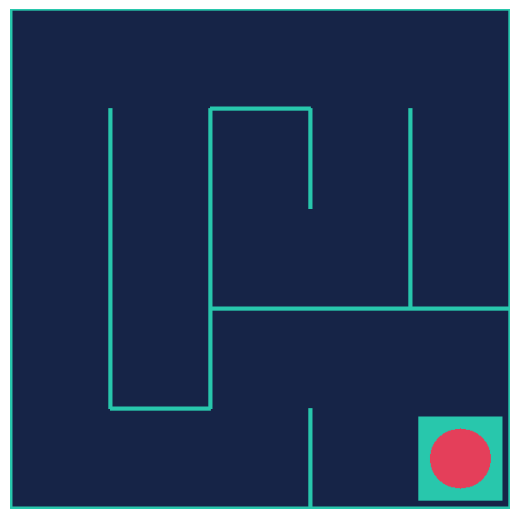

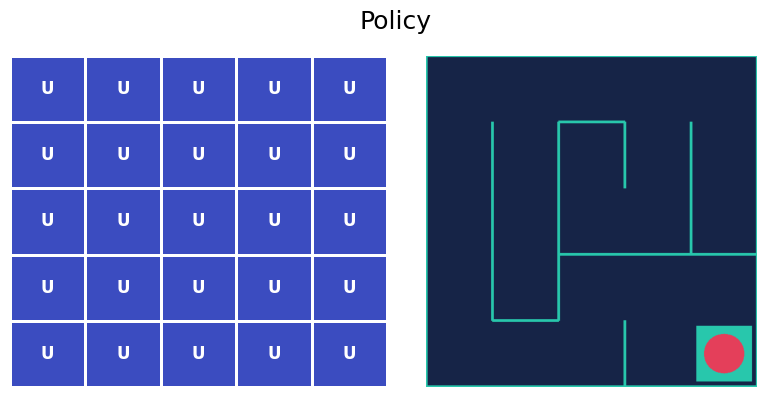

In [10]:
# Plot the policy

plot_policy(policy_probs, frame)

In [11]:
### Define the value table V(s)

In [12]:
# Create the V(s) table

state_values = np.zeros(shape=(5, 5))

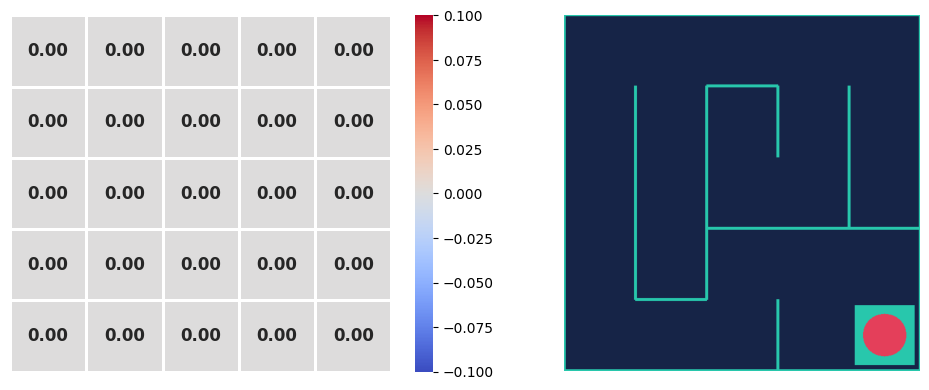

In [13]:
# Plot V(s)

plot_values(state_values, frame)

In [14]:
# Implement the Value Iteration algorithm

# policy_probs : một khởi tạo chiến lược với một phân phối xác suất lựa chọn hành động theo từng trạng thái
# state_values : một tập hợp giá trị khởi tạo của từng trạng thái, biểu diễn dưới dạng bảng


def value_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float('inf')

    while delta > theta:
        delta = 0
        for row in range(5):
            for col in range(5):
                state = (row, col)
                old_value = state_values[state] # V(s)
                action_probs = None
                max_qsa = float('-inf')

                for action in range(4):
                    next_state, reward, _, _ = env.simulate_step(state, action)
                    qsa = reward + gamma * state_values[next_state]

                    if qsa > max_qsa:
                        max_qsa = qsa
                        action_probs = np.zeros(4)
                        action_probs[action] = 1

                state_values[state] = max_qsa
                policy_probs[state] = action_probs

                delta = max(delta, abs(max_qsa - old_value))

                


In [15]:
# Do value iteration

value_iteration(policy_probs, state_values)

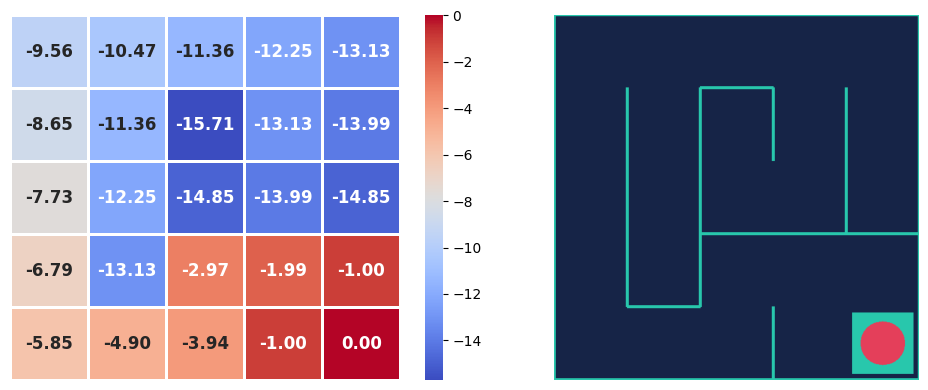

In [16]:
# Show V(s)

plot_values(state_values, frame)


In [17]:
state_values

array([[ -9.5617925 , -10.46617457, -11.36151283, -12.2478977 ,
        -13.12541872],
       [ -8.64827525, -11.36151283, -15.70568066, -13.12541872,
        -13.99416454],
       [ -7.72553056, -12.2478977 , -14.85422289, -13.99416454,
        -14.85422289],
       [ -6.79346521, -13.12541872,  -2.9701    ,  -1.99      ,
         -1.        ],
       [ -5.85198506,  -4.90099501,  -3.940399  ,  -1.        ,
          0.        ]])

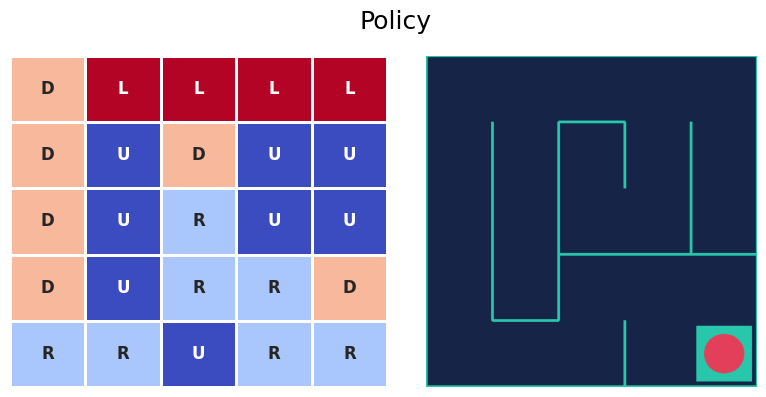

In [18]:
# Show policy pi(.|s)

plot_policy(policy_probs, frame)

In [19]:
# Test the result agent

test_agent(env, policy)